### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [ ]:
!pip install Image Pillow==5.1.0 scipy==1.1.0

In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn==0.20

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py

--2022-09-16 12:31:46--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-09-16 12:31:46 (56.0 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]



In [ ]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cuda:0") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

cuda:0


In [ ]:
BATCH_SIZE = 32

In [ ]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [ ]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [ ]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


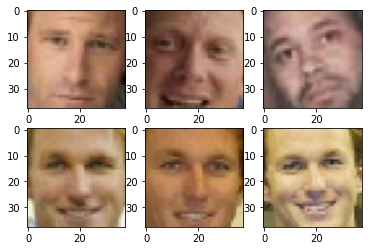

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [ ]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [ ]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [ ]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [ ]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [ ]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.005877310479500018


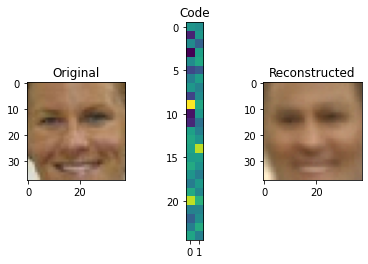

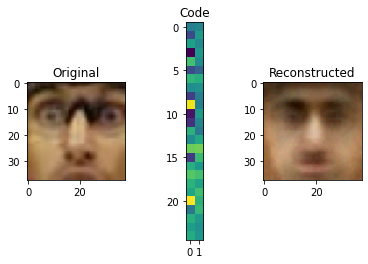

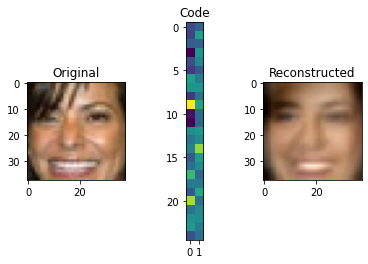

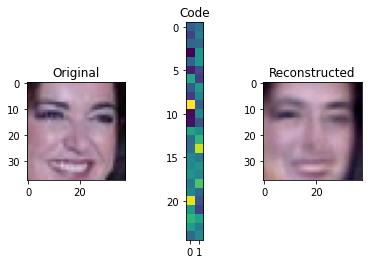

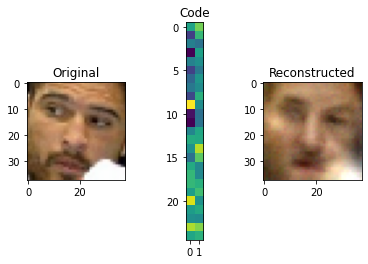

In [ ]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)

### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [ ]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)),
                                 nn.Linear(np.prod(img_shape), 256),
                                 nn.Linear(256, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, code_size),
                                 )
        self.dec = nn.Sequential(nn.Linear(code_size, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, 128),
                                 nn.Linear(128, 256),
                                 nn.Linear(256, np.prod(img_shape)),
                                 Reshape(-1, img_shape[0], img_shape[1], img_shape[2])
                                 ) 
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [ ]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=False)
        return x

class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(nn.Conv2d(3, 64, 3),
                                 nn.ReLU(),

                                 nn.MaxPool2d(2),

                                 nn.Flatten(),
                                 nn.Linear(20736, code_size)
                                 )
        self.dec = nn.Sequential(nn.Linear(code_size, 20736),
                                 nn.Unflatten(1, (64, 18, 18)),

                                 Interpolate(scale_factor=2, mode='bilinear'),

                                 nn.ReLU(),
                                 nn.ConvTranspose2d(64, 3, 3),
                                 ) 
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [ ]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).float().to(device)
    encoder_out = model.enc(help_tensor.float().cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()])),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [ ]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=50)

Training may take long, it's okay.

In [ ]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [ ]:
sigma=0.1
torch.normal(0, sigma, size=(3, 3))

tensor([[ 0.0998, -0.1235,  0.1049],
        [ 0.0161,  0.0601, -0.0507],
        [-0.0367, -0.1805, -0.1710]])

In [ ]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = torch.normal(0, sigma, size=tuple(X.size()))
        
    return X + noise
    

In [ ]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

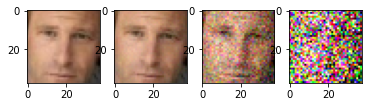

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [ ]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)  

370it [00:08, 42.92it/s]


1, Train loss: 0.10304352141179651, Test loss: 0.02382292989600296


370it [00:07, 48.04it/s]


2, Train loss: 0.021657729430477144, Test loss: 0.02089357330118416


370it [00:08, 44.59it/s]


3, Train loss: 0.01910394667606494, Test loss: 0.018555290990441


370it [00:07, 48.10it/s]


4, Train loss: 0.01687710032694068, Test loss: 0.016577085307680532


370it [00:07, 48.35it/s]


5, Train loss: 0.015014274558998866, Test loss: 0.01499885547550864


370it [00:07, 48.16it/s]


6, Train loss: 0.0135051653747843, Test loss: 0.013537750348841672


370it [00:07, 47.98it/s]


7, Train loss: 0.012325307182691632, Test loss: 0.012465886863387954


370it [00:07, 47.93it/s]


8, Train loss: 0.011391393649161407, Test loss: 0.012830108718377127


370it [00:07, 47.80it/s]


9, Train loss: 0.010659682193188203, Test loss: 0.011423207865680832


370it [00:07, 47.89it/s]


10, Train loss: 0.010177828136129633, Test loss: 0.011479086846101105


370it [00:07, 48.01it/s]


11, Train loss: 0.00950243548331466, Test loss: 0.01062866471431036


370it [00:07, 48.15it/s]


12, Train loss: 0.008782399945343612, Test loss: 0.012052245203418566


370it [00:07, 48.39it/s]


13, Train loss: 0.00809346807177965, Test loss: 0.00996902365643069


370it [00:07, 47.87it/s]


14, Train loss: 0.007530753186576728, Test loss: 0.009687499471904063


370it [00:08, 46.02it/s]


15, Train loss: 0.007089601513289479, Test loss: 0.009142388858041682


370it [00:07, 47.92it/s]


16, Train loss: 0.006781083496683726, Test loss: 0.008845898585862402


370it [00:07, 47.90it/s]


17, Train loss: 0.006550477847759295, Test loss: 0.00860877399500643


370it [00:07, 48.14it/s]


18, Train loss: 0.00638732312903949, Test loss: 0.008833658005667993


370it [00:07, 48.32it/s]


19, Train loss: 0.006275080924183578, Test loss: 0.009433861464913092


370it [00:07, 48.39it/s]


20, Train loss: 0.006142096826326294, Test loss: 0.00856260653187189


370it [00:07, 48.24it/s]


21, Train loss: 0.0060455599108986775, Test loss: 0.008097904207824564


370it [00:07, 48.18it/s]


22, Train loss: 0.005961087156693698, Test loss: 0.007223879602133329


370it [00:07, 47.93it/s]


23, Train loss: 0.0058719987334898815, Test loss: 0.007065287856731167


370it [00:07, 47.87it/s]


24, Train loss: 0.005781147189565899, Test loss: 0.006906583697888748


370it [00:07, 47.98it/s]


25, Train loss: 0.005704865866145829, Test loss: 0.006834008529370913


370it [00:07, 48.31it/s]


26, Train loss: 0.005614699325333446, Test loss: 0.006660762454256579


370it [00:07, 48.07it/s]


27, Train loss: 0.005533227144266465, Test loss: 0.006557231866204301


370it [00:07, 48.06it/s]


28, Train loss: 0.005441054566691066, Test loss: 0.006507090853465294


370it [00:07, 48.15it/s]


29, Train loss: 0.005379394159640568, Test loss: 0.006407373168835409


370it [00:07, 47.86it/s]


30, Train loss: 0.005308728123219396, Test loss: 0.006281691850787096


370it [00:07, 47.89it/s]


31, Train loss: 0.005238059159669243, Test loss: 0.006294727679692305


370it [00:07, 48.22it/s]


32, Train loss: 0.005184110236301608, Test loss: 0.006110365924048688


370it [00:07, 48.18it/s]


33, Train loss: 0.005122197091959889, Test loss: 0.0061387082655936665


370it [00:07, 48.11it/s]


34, Train loss: 0.005066044657147401, Test loss: 0.006107415459880308


370it [00:08, 45.87it/s]


35, Train loss: 0.005020039352556402, Test loss: 0.0060655714649906845


370it [00:07, 47.98it/s]


36, Train loss: 0.004970397482183719, Test loss: 0.0059333779686418274


370it [00:07, 47.60it/s]


37, Train loss: 0.0049270973341241486, Test loss: 0.0060380357713626905


370it [00:07, 47.90it/s]


38, Train loss: 0.0048851119382800085, Test loss: 0.0058809613535008645


370it [00:07, 47.85it/s]


39, Train loss: 0.0048504164907889145, Test loss: 0.0058999717756894705


370it [00:07, 48.34it/s]


40, Train loss: 0.0048115487536761845, Test loss: 0.005941313295906471


370it [00:07, 47.79it/s]


41, Train loss: 0.0047765869692724585, Test loss: 0.005883175969399938


370it [00:07, 48.07it/s]


42, Train loss: 0.0047425789760729715, Test loss: 0.005877225268044403


370it [00:07, 48.11it/s]


43, Train loss: 0.0047166301464824055, Test loss: 0.005825542327778594


370it [00:07, 48.06it/s]


44, Train loss: 0.004684087068272821, Test loss: 0.005741326349203155


370it [00:07, 48.04it/s]


45, Train loss: 0.004650041813074039, Test loss: 0.005721542824143434


370it [00:07, 47.96it/s]


46, Train loss: 0.004628617476216376, Test loss: 0.005784235613826035


370it [00:07, 47.98it/s]


47, Train loss: 0.004601565267216391, Test loss: 0.00576595923226609


370it [00:07, 48.02it/s]


48, Train loss: 0.004573354614562724, Test loss: 0.0057177601092507765


370it [00:07, 48.13it/s]


49, Train loss: 0.0045540026301884836, Test loss: 0.005703688075440417


370it [00:07, 47.95it/s]


50, Train loss: 0.004531508356437614, Test loss: 0.005584552715659698


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

torch.Size([3, 3, 38, 38])
Final MSE: 0.005253924599425384


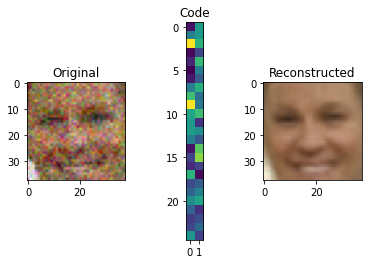

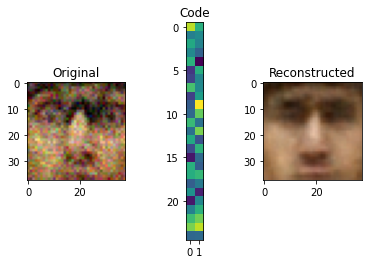

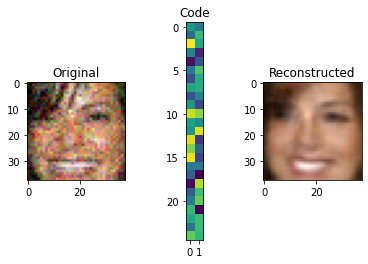

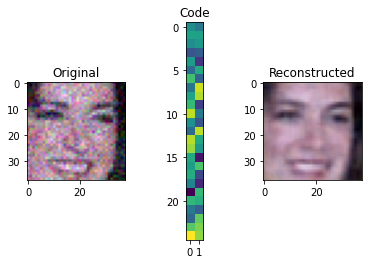

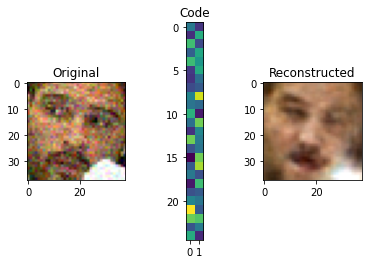

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)
print(batch.shape)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
for i in X_train_tensor:
  print(i.shape)
  break

torch.Size([3, 38, 38])


In [ ]:
#encodes batch of images into a codes

codes = np.array([aenc.enc(torch.unsqueeze(i, 0).to(device)).detach().cpu().numpy() for i in X_train_tensor]) #<encode all images in X_train_tensor>

In [ ]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [ ]:
#codes = codes.squeeze(1)

In [ ]:
codes.device

AttributeError: ignored

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [ ]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.unsqueeze(0).cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


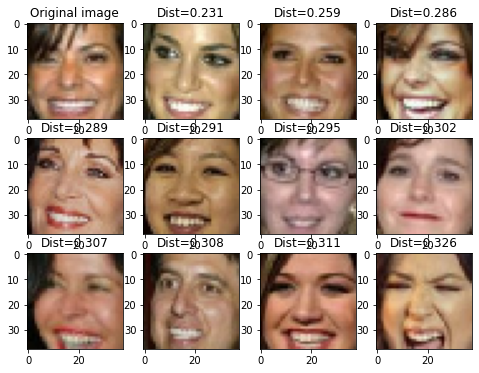

In [ ]:
#smiles
show_similar(X_test_tensor[2])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


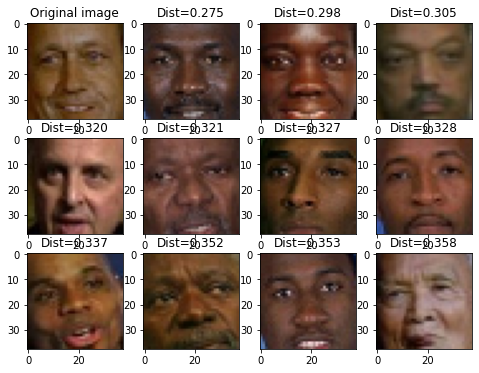

In [ ]:
#ethnicity
show_similar(X_test_tensor[500])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


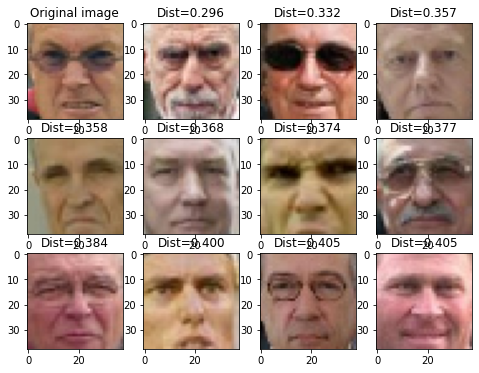

In [ ]:
#glasses
show_similar(X_test_tensor[66])

In [ ]:
X_test_tensor[66].shape

torch.Size([3, 38, 38])

## Bonus: cheap image morphing


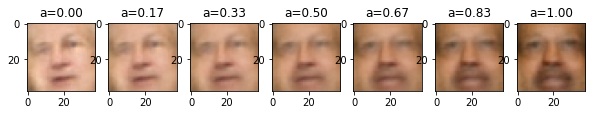

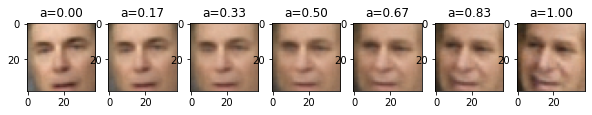

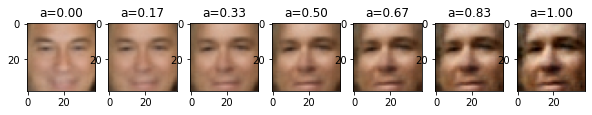

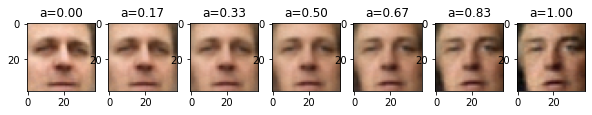

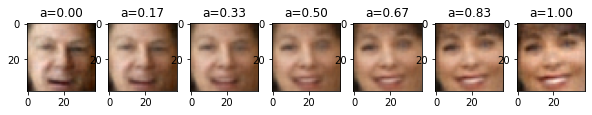

In [ ]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    #image_pair = torch.permute((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1 = aenc.enc(image1.unsqueeze(0).cuda())
    code2 = aenc.enc(image2.unsqueeze(0).cuda())

    #print(code1.shape)
    #print(code2.shape)
    a = 0.4
    output_code = code1*(1-a) + code2*(a)
    #print(output_code.shape)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code)[0]

        output_image[output_image > 1] = 1
        output_image[output_image < 0] = 0

        plt.subplot(1,7,i+1)
        plt.imshow(np.transpose(output_image.cpu().detach().numpy(), (1, 2, 0)))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.